In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import ast
from glob import glob

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
train_files = glob("../input/train_simplified/*.csv")

# Any results you write to the current directory are saved as output.

['test_simplified.csv', 'sample_submission.csv', 'train_simplified', 'test_raw.csv']


In [2]:
# Reading training data
NROWS=1200
data = pd.DataFrame()
for f in train_files:
    data = data.append(pd.read_csv(f, 
                   index_col="key_id", nrows=NROWS))

data["word"] = data["word"].replace("\s+", "_", regex=True)

data = data.sample(frac=1, replace=False)
data.head()

,countrycode,drawing,recognized,timestamp,word
key_id,,,,,
6601016092917760,US,"[[[178, 144, 116, 101, 98, 60, 30, 19, 18, 25,...",True,2017-03-24 20:00:18.942880,brain
5800229758566400,US,"[[[85, 81, 93, 156, 167, 170], [124, 122, 121,...",True,2017-03-07 01:29:28.450620,fireplace
5787338129014784,DE,"[[[233, 179, 42, 21, 14, 0, 2, 13, 173, 198, 2...",True,2017-03-20 14:56:36.979250,hurricane
4520547406839808,US,"[[[1, 2, 8, 29, 53, 59, 64, 77, 96, 107, 126, ...",True,2017-03-12 03:22:49.205790,speedboat
5000252320907264,MA,"[[[2, 3, 9, 20, 29, 36, 74, 115, 131, 161, 198...",True,2017-03-27 00:06:12.816080,bathtub


In [3]:
# Reading test file
test = pd.read_csv('../input/test_simplified.csv', index_col="key_id")
test.head()
testidx = test.index

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


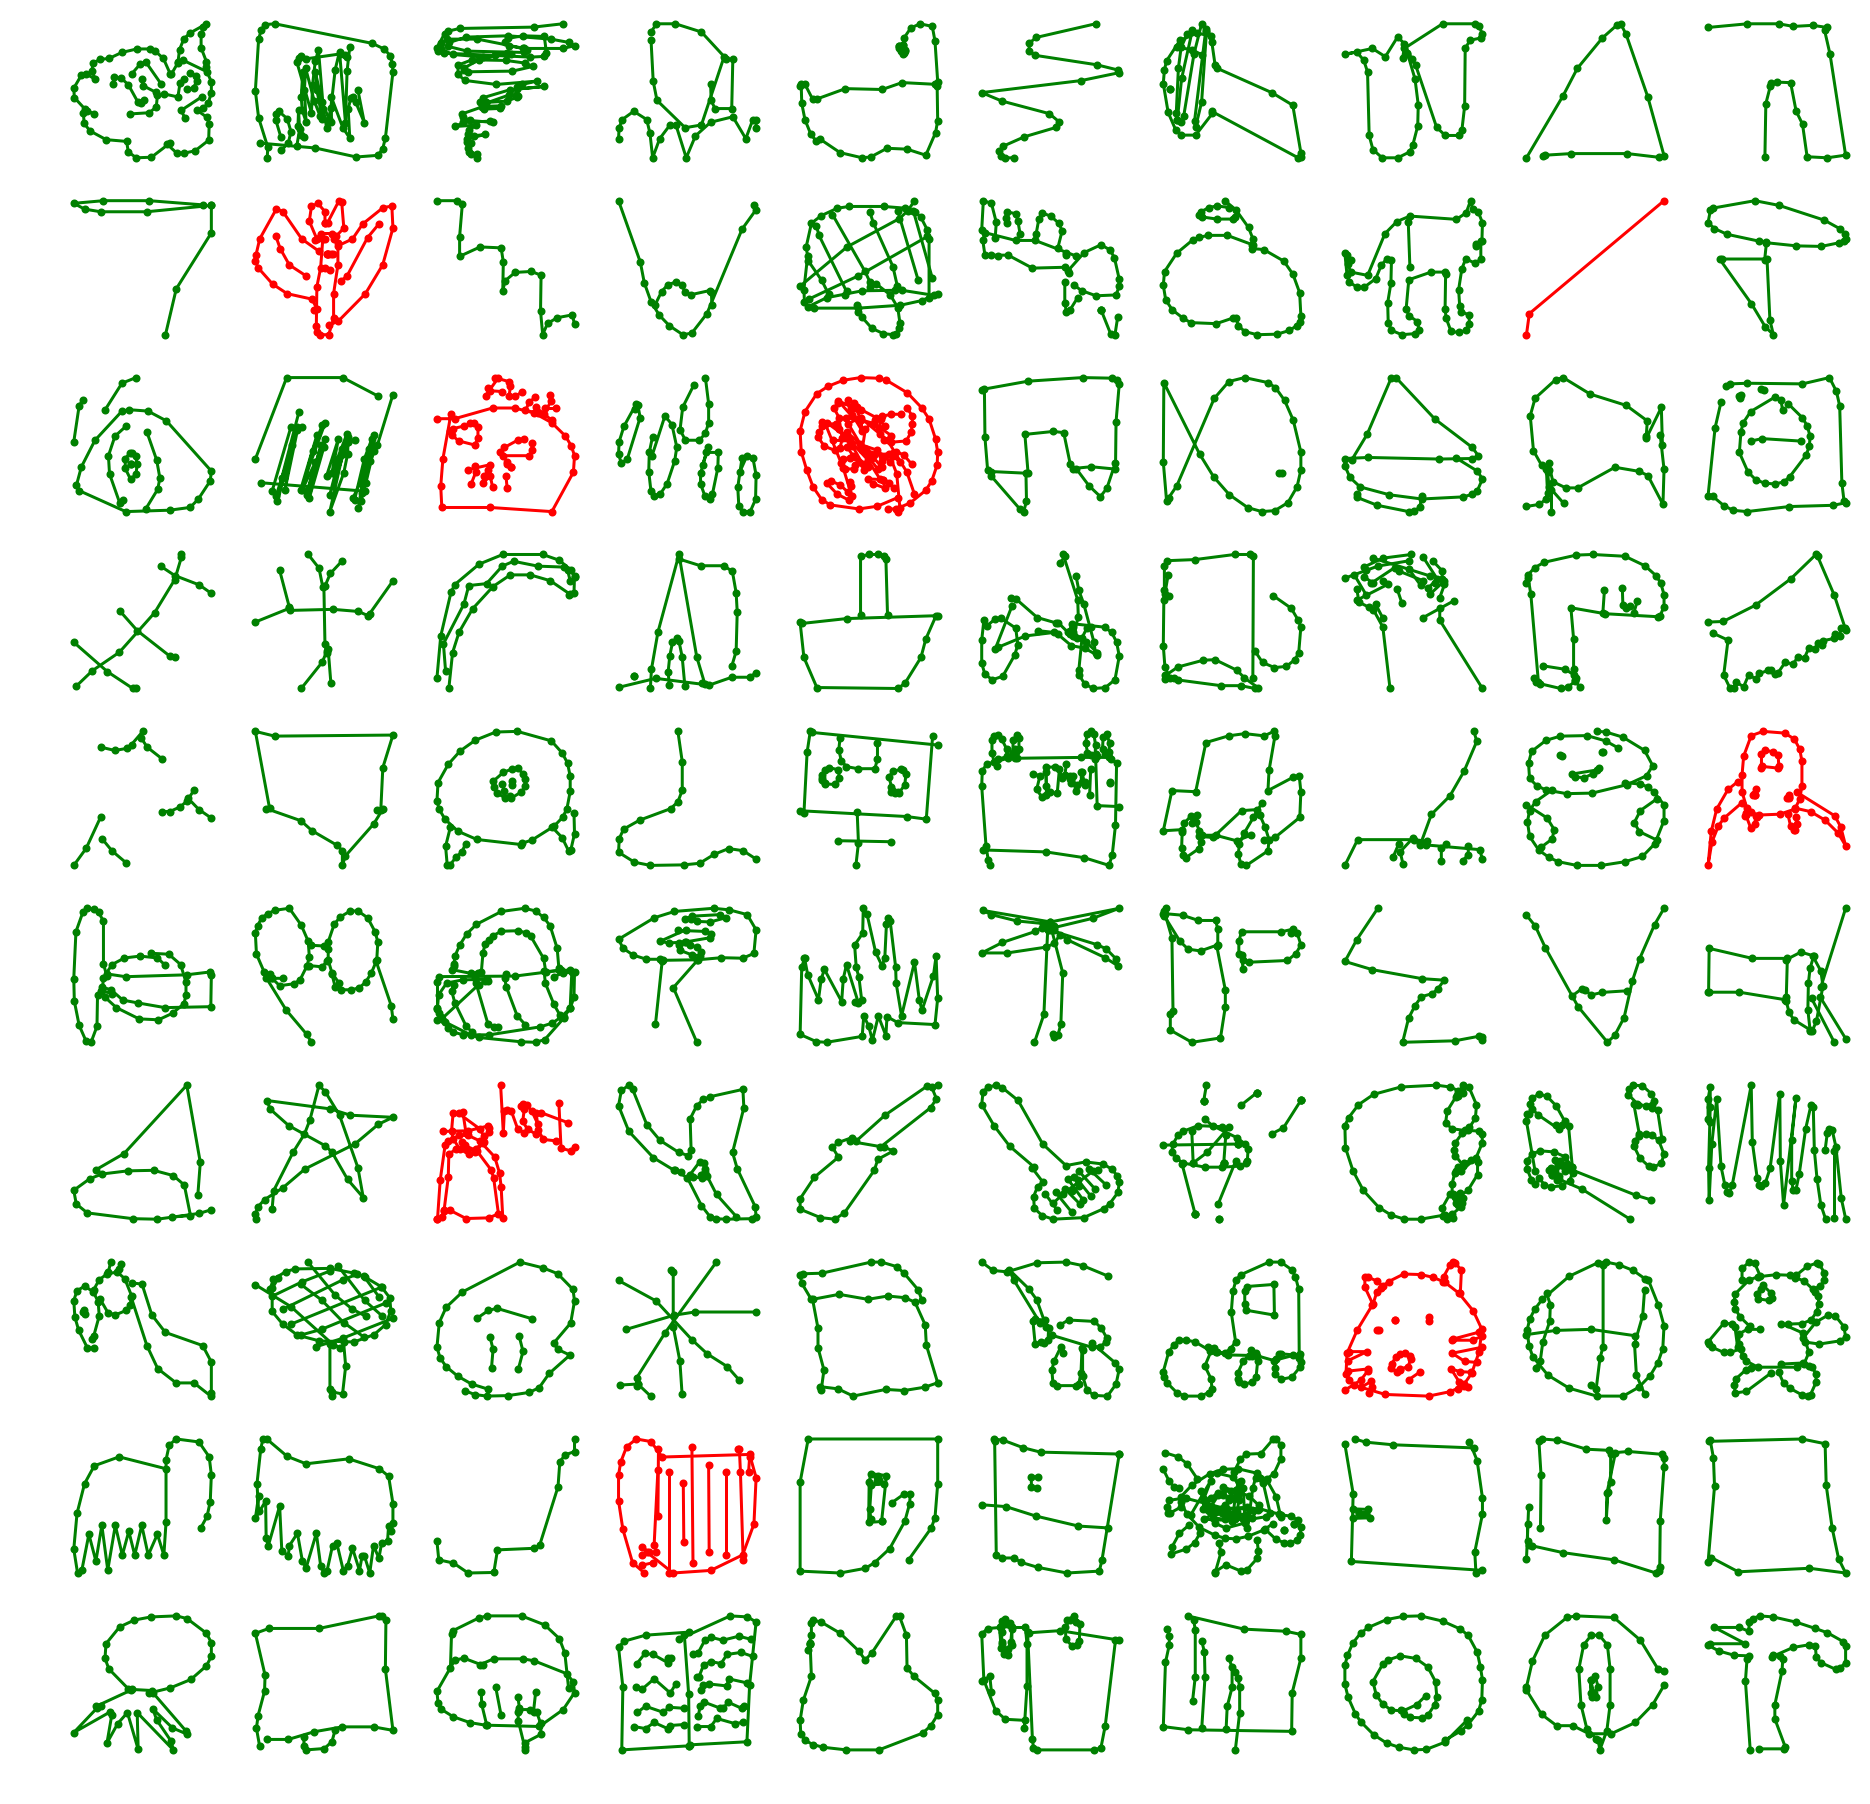

In [4]:
print_ids = data.iloc[:100].index
data_images = [ast.literal_eval(lst) for lst in data.loc[print_ids, 'drawing'].values]
# Plot parrot figures, coloring as green if they're recognized,
# red otherwise.
plt.figure(figsize=(16, 16))
for index, image in enumerate(data_images):
    for x, y in image:
        plt.subplot(10, 10, index+1)
        col = "green" if data["recognized"].iloc[index] else "red"
        plt.gca().invert_yaxis()
        plt.axis("off")
        plt.plot(x, y, marker=".", color=col)

plt.show()

In [5]:
# Rasterizing vector images
from PIL import Image, ImageDraw
from dask import bag

SIZE = 32
# Rasterizarion algorithm from https://www.kaggle.com/jpmiller/image-based-cnn#
def draw_it(strokes, imheight=32, imwidth=32):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

imagebag = bag.from_sequence(data.drawing.values).map(draw_it, 
                                                      imheight=SIZE, 
                                                      imwidth=SIZE)
raster_array = np.array(imagebag.compute())

imagebag = bag.from_sequence(test.drawing.values).map(draw_it, 
                                                      imheight=SIZE, 
                                                      imwidth=SIZE)

test_X = np.array(imagebag.compute())

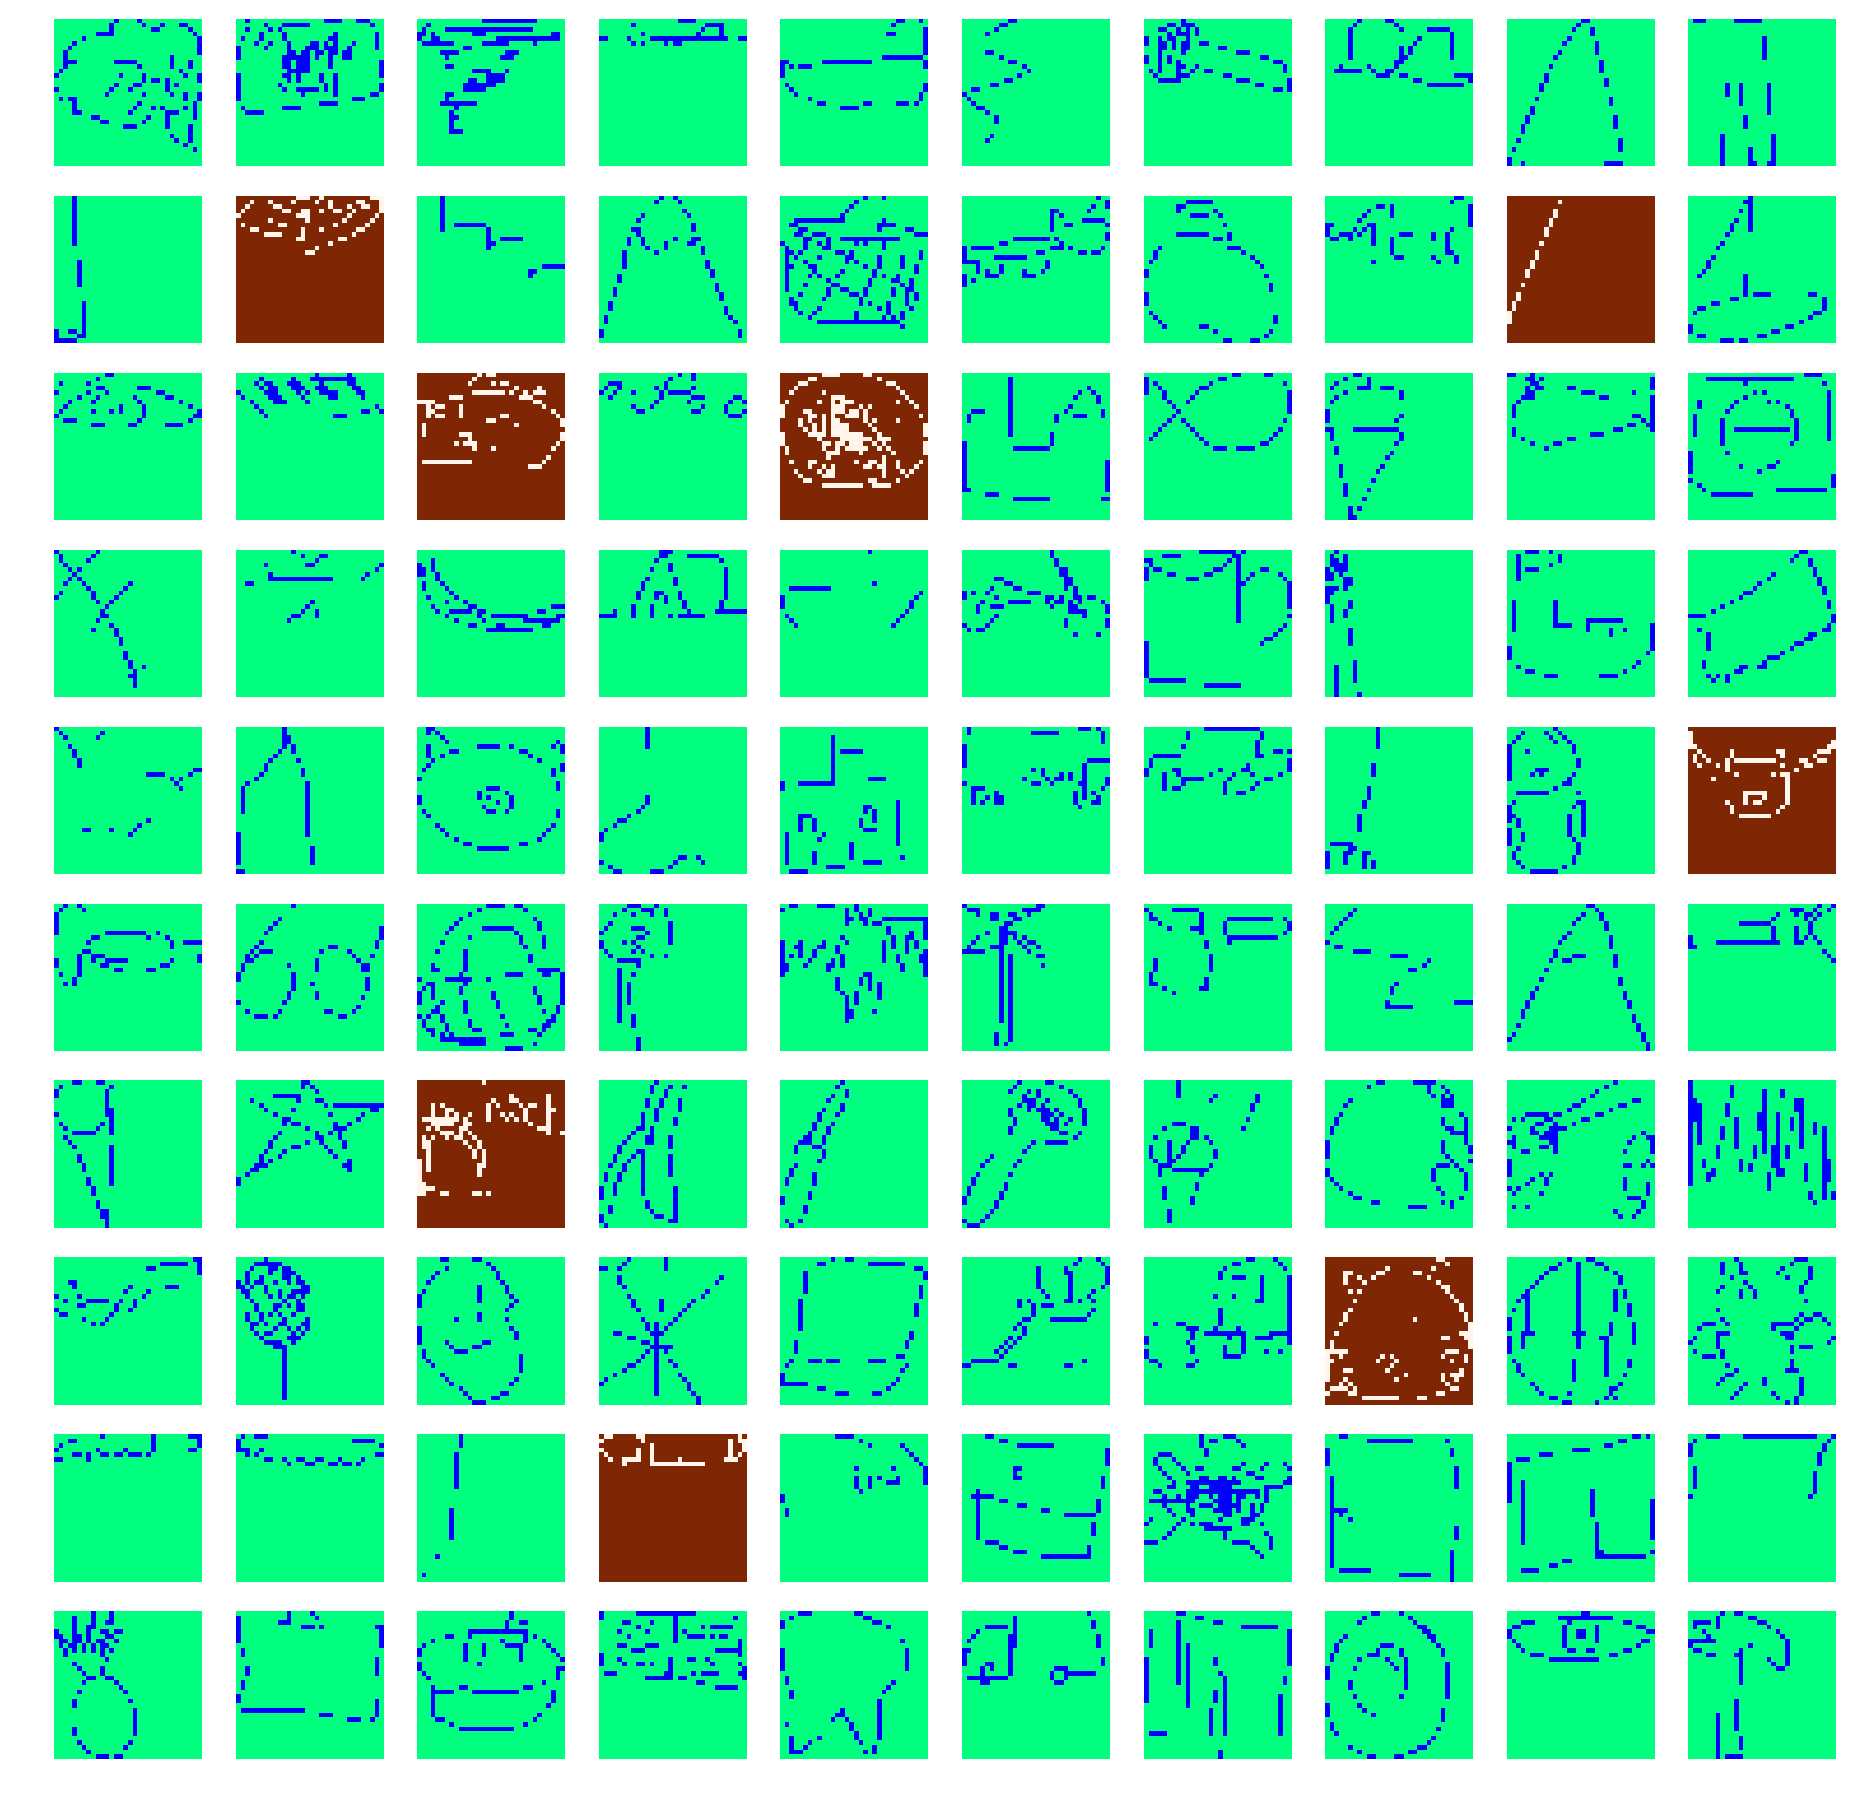

In [6]:
# Print rasterized images
plt.figure(figsize=(16, 16))
for index, image in enumerate(raster_array[:100]):
    plt.subplot(10, 10, index+1)
    col = "winter" if data["recognized"].iloc[index] else "Oranges"
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.imshow(image, cmap=col)

plt.show()

In [7]:
raster_array = raster_array.reshape(-1, SIZE,SIZE, 1)
test_X = test_X.reshape(-1, SIZE,SIZE, 1)

In [8]:
# get dummies from classes and delete dataframes for memory
dummies = pd.get_dummies(data['word'])

In [9]:
del data, test

In [10]:
# Split training data for validation
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(raster_array, dummies, test_size=0.2, random_state=13)

In [11]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((326400, 32, 32, 1), (81600, 32, 32, 1), (326400, 340), (81600, 340))

In [12]:
# Constants
BATCH_SIZE = 64
EPOCHS = 40
NUM_CLASSES = 340
SHAPE = (SIZE, SIZE, 1)
FILTER_SIZE = (4, 4)
PROB_DO_HIDDEN = 0.3

In [28]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation


model = Sequential()
model.add(Conv2D(32, kernel_size=FILTER_SIZE, strides=1, input_shape=SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(PROB_DO_HIDDEN))

model.add(Conv2D(64, kernel_size=FILTER_SIZE, strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(PROB_DO_HIDDEN))

# model.add(Conv2D(128, kernel_size=FILTER_SIZE, strides=1))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(PROB_DO_HIDDEN))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(PROB_DO_HIDDEN))

model.add(Dense(NUM_CLASSES))
model.add(Activation('softmax'))

In [29]:
# Fonte: https://stackoverflow.com/questions/42327006/how-to-calculate-top5-accuracy-in-keras
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

In [30]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy', top3_acc])

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 29, 29, 32)        544       
_________________________________________________________________
activation_17 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_18 (Activation)   (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)          0         
__________

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=int(EPOCHS*0.2))

history = model.fit(train_X, train_label, batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=1,validation_data=(valid_X, valid_label), callbacks=[early_stopping_monitor])

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['top3_acc'])
plt.plot(history.history['val_top3_acc'])
plt.title('Model accuracy (top 3)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Predict test dataset with model
test_Y = model.predict(test_X, batch_size=BATCH_SIZE)

In [ ]:
# Get top 3 classes
ans = np.argsort(-test_Y)[:,:3]

In [ ]:
ans

In [ ]:
# Generating output
out_aux = []
for id, i in zip(testidx, dummies.columns[ans]):
    out_aux.append([id, " ".join(map(str, i))])

output = pd.DataFrame(columns=['key_id', 'word'], data=out_aux)

In [ ]:
output.to_csv("submission.csv")